In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import gensim
import re
import nltk
from tqdm import tqdm

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

In [2]:
!pip install pyLDAvis
from gensim import models
from gensim.models.coherencemodel import CoherenceModel

In [3]:
#Set working directory
#@title Set up Directory { run: "auto"}
import os
from IPython.display import clear_output
from google.colab import drive 
from IPython.display import clear_output
drive.mount('/content/gdrive')
working_directory = 'My Drive/Khairiyah_Bte_Mohamed_Ridhwan/topic_modelling/notebooks' #@param {type:"string"}
wd="/content/gdrive/"+working_directory
os.chdir(wd)

dirpath = os.getcwd()
print("current directory is : " + dirpath)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
current directory is : /content/gdrive/My Drive/Khairiyah_Bte_Mohamed_Ridhwan/topic_modelling/notebooks


In [4]:
# Import customs module to tokenize and clean tweet dataset
from clean_tokenizer import tokenize_tweets, clean_tweet
tweets_df = pd.read_csv('data/tweets_final_vader.csv') 
tweets_df.shape

(5267, 21)

In [5]:
date = pd.to_datetime(tweets_df['Datetime'], format='%Y-%m-%d')
tweets_df['date'] = date.dt.date

# Convert date to datetime
tweets_df['date'] = pd.to_datetime(tweets_df['date'], errors='coerce')

# Add column for month
tweets_df['month'] = tweets_df['date'].dt.month

# Add column for week number
tweets_df['week'] = tweets_df['date'].apply(lambda x: x.isocalendar()[1])

### Data preprocessing


In [6]:
import nltk
nltk.download('wordnet')
# Convert cleaned tweet into tokens list
tweets_df['Text']=tweets_df['Text'].apply(str)
tweets_df['Text'] = tweets_df['Text'].replace({'govt':'government', 'Govt':'Government'} )
tweets_df['clean_text_new']=tweets_df['Text'].apply(clean_tweet, bigrams=True)
#   Note: clean_tweet function will: 
# -	remove retweet and @user information
# -	remove web links
# -	remove hashtags
# -	remove audio/video tags or labels
# -	lower case the tweet
# -	strip punctuation
# -	remove double spacing
# -	remove numbers
# -	apply lemmatization and tokenization (within lemmatize function, remove stop words, drops words with 3 or less characters
# -	form bigrams
tweets_df.head()
tweets_df['clean_tokens'] = tweets_df.clean_text_new.apply(lambda x: re.split('\s', x))
#remove additional custom stopwords
stop = ["pm","t.co","http","https","amp","t","t.c","c","rt", "pl", "sg","singapore", "covid-19","coronavirus", "covid",
        "covid19","wuhan", "s", "p", "like", "im","new", "day", "days","year", "ur", "ve", "la", "ive", "cos", "guys",
        "didnt", "time", "people", "dont", "today", "thing", "week", "months", "post","yesterday", "man", "wont", "uk",
        "st", "lets", "don", "feel", "feeling", "gonna","isnt", "pls", "share", "wait", "wanna", "na", "back", "means",
        "fuck", "fucking", "lah", "good","due", "sa", "ingat", "sa covid", "just", "will", "can", "now", "get", "go", "us",
        "can", "one", "even", "just", "ada", "ke", "got", "going", "last", "etc", "kaypo", "still", "chibai", "woodlands",
        "singapore", "woodlands_singapore", "say", "know", "virus","situation", "need", "want", "take", "come", "look",
        "think", 'actually', 'especially', 'later', 'guess', 'note', 'dear', 'road', 'start', 'stop', 'things', 'give',
        'try', 'tell', 'shit', 'maybe', 'keep', 'right','time', 'march_march', 'stacy',  'time_coronavirus', 'amid_covid', 
        'ingat_covid', 'iwas','mall','bedok', 'control', 'lawrence', 'wong', 'lawrence_wong', 'feel_like']
tweets_df['clean_tokens_final']= tweets_df['clean_tokens'].apply(lambda x: [item for item in x if item not in stop])
tweets_df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Datetime,Tweet.URL,Tweet.Id,Tweet.User.Id,Text,Username,User.Location,replyCount,retweetCount,likeCount,quoteCount,language,retweetedTweet,quotedTweet,mentionedUsers,clean_text,date,month,week,sentiment_score,sentiment_label,clean_text_new,clean_tokens,clean_tokens_final
0,2020-08-31 22:27:32+00:00,https://twitter.com/VishnoiSays/status/1300560...,1.300561e+18,8.134247e+07,Canada Buying Doses of Covid-19 Vaccine From N...,VishnoiSays,Singapore,0,0,0,0,en,NaN,NaN,NaN,canada buying doses covid vaccine novavax j amp j,2020-08-31,8,36,0.0000,neutral,canada buy dose covid vaccine novavax canada_b...,"[canada, buy, dose, covid, vaccine, novavax, c...","[canada, buy, dose, vaccine, novavax, canada_b..."
1,2020-08-31 22:27:32+00:00,https://twitter.com/VishnoiSays/status/1300560...,1.300561e+18,8.134247e+07,Heat Waves Hurting Cities Most Vulnerable to C...,VishnoiSays,Singapore,0,0,0,0,en,NaN,NaN,NaN,heat waves hurting cities vulnerable covid,2020-08-31,8,36,-0.5984,negative,heat wave hurt cities vulnerable covid heat_wa...,"[heat, wave, hurt, cities, vulnerable, covid, ...","[heat, wave, hurt, cities, vulnerable, heat_wa..."
2,2020-08-31 16:07:16+00:00,https://twitter.com/onefern/status/13004651859...,1.300465e+18,5.447890e+08,One of my fave after dinner snacks nowadays if...,onefern,Singapore,0,0,0,0,en,NaN,NaN,NaN,one fave dinner snacks nowadays m still peckis...,2020-08-31,8,36,0.4404,positive,fave dinner snack nowadays peckish period fave...,"[fave, dinner, snack, nowadays, peckish, perio...","[fave, dinner, snack, nowadays, peckish, perio..."
3,2020-08-31 14:25:48+00:00,https://twitter.com/sinsica/status/13004396509...,1.300440e+18,2.384276e+08,Please be safe guys .. take all precautions an...,sinsica,Singapore,0,0,1,0,en,NaN,NaN,NaN,please safe guys take precautions safety measu...,2020-08-31,8,36,0.7003,positive,safe guy precautions safety measure avoid crow...,"[safe, guy, precautions, safety, measure, avoi...","[safe, guy, precautions, safety, measure, avoi..."
4,2020-08-31 11:49:25+00:00,https://twitter.com/heroroxas/status/130040029...,1.300400e+18,1.964754e+09,Where i'd rather be kasi it's covid-free #tb @...,heroroxas,NaN,0,0,0,0,en,NaN,NaN,NaN,d rather kasi s covid free batanes philippines,2020-08-31,8,36,0.0000,neutral,kasi covid free batanes philippines kasi_covid...,"[kasi, covid, free, batanes, philippines, kasi...","[kasi, free, batanes, philippines, kasi_covid,..."


In [14]:
all_words = [word for item in list(tweets_df['clean_tokens_final']) for word in item]
#all_words

#frequency distribution of all terms
fdist = nltk.FreqDist(all_words)

#number of unique terms
len(fdist)
#fdist

48057

In [15]:
#create dataframe of terms with their respective frequency
fdist = pd.DataFrame.from_dict(fdist, orient='index').reset_index()
fdist.columns = ['word', 'freq']
fdist = fdist.sort_values('freq', ascending=False)

In [16]:
#discard words containing only 1 character
fdist = fdist[fdist.apply(lambda r: len(r['word']) > 1, axis=1)]

#discard numbers/digits
fdist = fdist[fdist.apply(lambda r: r['word'].isdigit() == False, axis=1)]

#select terms that appear at least 10 times
fdist = fdist[(fdist.freq >= 10)]

In [17]:
fdist.head()

,word,freq
196,case,365
397,home,352
1347,stay,295
378,work,272
248,world,230


In [18]:
len(fdist)

1028

In [31]:
#dictionary to collect order of mapping
dict_word = {}
for i in range(len(fdist)):
    temp = fdist.iloc[i]
    word = temp['word']
    dict_word[word] = word


#mapping
tweets_df['cleaned'] = tweets_df.apply(lambda row: [dict_word[x] for x in row.clean_tokens_final if x in dict_word.keys() ], axis=1)

#removing stopwords
tweets_df['cleaned'] = tweets_df.apply(lambda row: [x for x in row.cleaned if x not in stop], axis=1)

In [32]:
all_words = [word for item in list(tweets_df['cleaned']) for word in item]

#distribution of word frequency
fdist = nltk.FreqDist(all_words)
print('No. of unique terms: ',len(fdist))

No. of unique terms:  1028


Average length of tweet:  5.475982532751091
Mode of length of tweet:  3
Number of tweets with length 0:  256
Number of tweets with length 1:  500


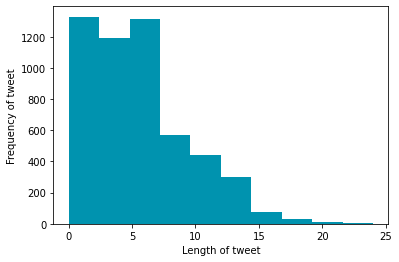

In [33]:
length = [len(x) for x in tweets_df['cleaned']]
#length_counts = length.value_counts()
plt.hist(length, color='#0093AF');
plt.xlabel('Length of tweet')
plt.ylabel('Frequency of tweet')
print('Average length of tweet: ', np.mean(length))
print('Mode of length of tweet: ', np.argmax(np.bincount(length)))
print('Number of tweets with length 0: ', length.count(0))
print('Number of tweets with length 1: ', length.count(1))

In [34]:
df_filtered = tweets_df[tweets_df.apply(lambda r: len(r['cleaned']) >= 2, axis=1)]
df_filtered.shape

(4511, 25)

Average length of tweet:  6.282864109953447


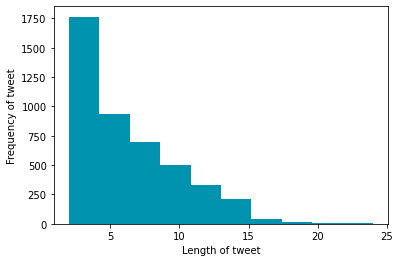

In [35]:
length = [len(x) for x in df_filtered['cleaned']]
plt.hist(length, color='#0093AF');
plt.xlabel('Length of tweet')
plt.ylabel('Frequency of tweet')
print('Average length of tweet: ', np.mean(length))

# Latent Dirichlet Allocation (LDA)

In [19]:
#preparation
texts = list(df_filtered['cleaned'])
id2word = gensim.corpora.Dictionary(texts)
corpus = [id2word.doc2bow(text) for text in texts]

#choose no. of topics based on coherence score
num_topics = np.arange(5,80+1, 5)
coherences = []
models = []

for num_topic in num_topics:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topic, 
                                           random_state=100,
                                           chunksize=6000,
                                           passes=20,
                                           alpha='auto',
                                           eta='auto',
                                           eval_every=None)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    coherences.append(coherence_score)
    models.append(lda_model)

KeyboardInterrupt: ignored

In [ ]:
coherences

[0.29584876128912835,
 0.35385247830721184,
 0.4073294006907466,
 0.42620379082646476,
 0.42071252081722854,
 0.4559998798789939,
 0.4658684506462718,
 0.4828126347735108,
 0.490800615902288,
 0.5045034823674017,
 0.49567899703546897,
 0.49254210280434607,
 0.4873709583873979,
 0.49566524548261476,
 0.4824552457569555,
 0.48596771797167315]

Text(0.5, 1.0, 'Topic Coherence')

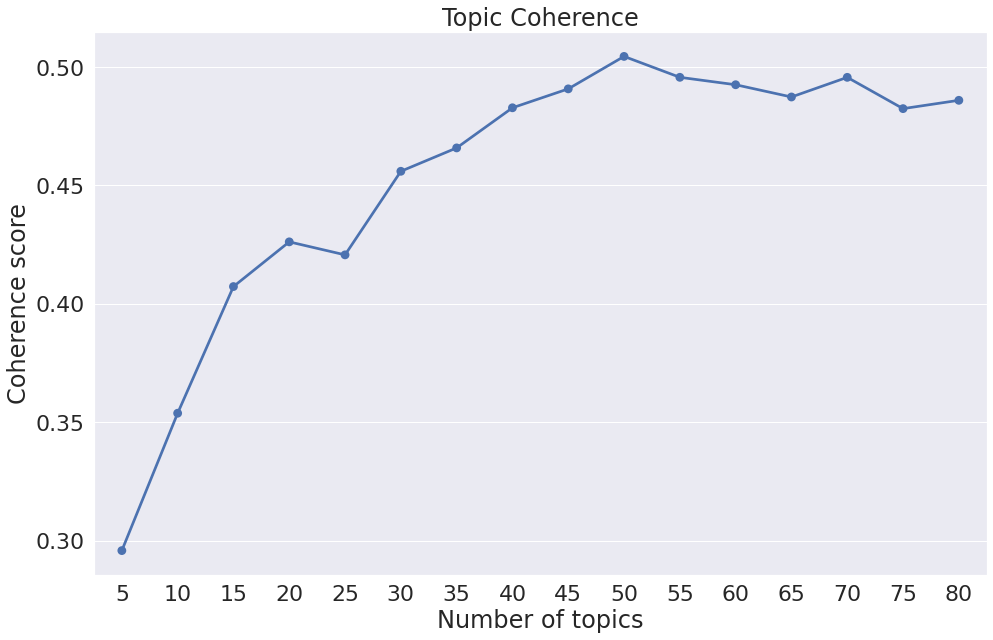

In [ ]:
# Plot coherence scores across topic numbers
sns.reset_orig()
sns.set(font_scale = 2)
plotData = pd.DataFrame({'Number of topics':num_topics,
                         'Coherence score':coherences})
f,ax = plt.subplots(figsize=(16,10))
#sns.set_style("darkgrid")
#sns.set(font_scale = 0.1)
sns.pointplot(x='Number of topics', y= 'Coherence score',data=plotData)
#plt.axhline(y=coherences[7], color='red', linestyle='--' )
#plt.axvline(x=6, color='red', linestyle='--' )
plt.title('Topic Coherence')

# GSDMM (Short Text Topic Modelling)

In [36]:
# Import module from gsdmm repository
import sys
sys.path.insert(0, '../gsdmm/')
from gsdmm import MovieGroupProcess

import pickle
import os

docs = df_filtered['cleaned'].tolist()
vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)

In [ ]:
import random
random.seed(1000)
mgp = MovieGroupProcess(K=35, alpha=0.1, beta=0.1, n_iters=40)
y = mgp.fit(docs, n_terms)

In [ ]:
# Save GSDMM model as pickle file

# import pickle

# filehandler = open("submit_model.pkl","wb")
# pickle.dump(mgp,filehandler)
# filehandler.close()

In [37]:
# Load GSDMM model from saved pickle file

import pickle

with open('submit_model.pkl', 'rb') as f:
 mgp = pickle.load(f)
 f.close()

In [38]:
# try saved model
import operator

for i in range(35):
    print('Cluster ' + str(i))
    print(sorted(mgp.cluster_word_distribution[i].items(),key = operator.itemgetter(1),reverse = True)[:10])
    print('*' * 20)

Cluster 0
[('travel', 15), ('temperature', 10), ('restrictions', 9), ('baby', 8), ('screen', 7), ('check', 7), ('travel_restrictions', 7), ('airport', 6), ('flight', 6), ('help', 6)]
********************
Cluster 1
[('test', 11), ('free', 11), ('swab', 10), ('changi', 8), ('airport', 8), ('changi_airport', 8), ('home', 7), ('covid_free', 7), ('live', 6), ('afternoon', 6)]
********************
Cluster 2
[('fight', 41), ('help', 23), ('fight_covid', 18), ('support', 16), ('thank', 13), ('nurse', 13), ('world', 12), ('frontline', 11), ('workers', 10), ('fight_coronavirus', 10)]
********************
Cluster 3
[('news', 24), ('spread', 16), ('china', 13), ('media', 10), ('viruses', 9), ('message', 9), ('alcohol', 8), ('blame', 8), ('fake', 8), ('trump', 7)]
********************
Cluster 4
[('outbreak', 25), ('soon', 21), ('hope', 16), ('vaccine', 15), ('world', 14), ('end', 11), ('economy', 11), ('travel', 11), ('cancel', 10), ('coronavirus_outbreak', 10)]
********************
Cluster 5
[('wo

In [39]:
sum(mgp.cluster_doc_count)

4511

In [40]:
topics = []
for i in range(len(docs)):
    topics.append(mgp.choose_best_label(docs[i])[0])
    
df_filtered['sttm_topic_from_zero'] = topics

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [41]:
# shift index of topics to +1 such that it starts from 0 instead of 1
df_filtered['sttm_topic'] = df_filtered['sttm_topic_from_zero'] + 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [42]:
df_filtered.head()

,Datetime,Tweet.URL,Tweet.Id,Tweet.User.Id,Text,Username,User.Location,replyCount,retweetCount,likeCount,quoteCount,language,retweetedTweet,quotedTweet,mentionedUsers,clean_text,date,month,week,sentiment_score,sentiment_label,clean_text_new,clean_tokens,clean_tokens_final,cleaned,sttm_topic_from_zero,sttm_topic
0,2020-08-31 22:27:32+00:00,https://twitter.com/VishnoiSays/status/1300560...,1.300561e+18,8.134247e+07,Canada Buying Doses of Covid-19 Vaccine From N...,VishnoiSays,Singapore,0,0,0,0,en,NaN,NaN,NaN,canada buying doses covid vaccine novavax j amp j,2020-08-31,8,36,0.0000,neutral,canada buy dose covid vaccine novavax canada_b...,"[canada, buy, dose, covid, vaccine, novavax, c...","[canada, buy, dose, vaccine, novavax, canada_b...","[buy, vaccine, covid_vaccine]",21,22
1,2020-08-31 22:27:32+00:00,https://twitter.com/VishnoiSays/status/1300560...,1.300561e+18,8.134247e+07,Heat Waves Hurting Cities Most Vulnerable to C...,VishnoiSays,Singapore,0,0,0,0,en,NaN,NaN,NaN,heat waves hurting cities vulnerable covid,2020-08-31,8,36,-0.5984,negative,heat wave hurt cities vulnerable covid heat_wa...,"[heat, wave, hurt, cities, vulnerable, covid, ...","[heat, wave, hurt, cities, vulnerable, heat_wa...","[wave, cities]",9,10
2,2020-08-31 16:07:16+00:00,https://twitter.com/onefern/status/13004651859...,1.300465e+18,5.447890e+08,One of my fave after dinner snacks nowadays if...,onefern,Singapore,0,0,0,0,en,NaN,NaN,NaN,one fave dinner snacks nowadays m still peckis...,2020-08-31,8,36,0.4404,positive,fave dinner snack nowadays peckish period fave...,"[fave, dinner, snack, nowadays, peckish, perio...","[fave, dinner, snack, nowadays, peckish, perio...","[dinner, period]",17,18
3,2020-08-31 14:25:48+00:00,https://twitter.com/sinsica/status/13004396509...,1.300440e+18,2.384276e+08,Please be safe guys .. take all precautions an...,sinsica,Singapore,0,0,1,0,en,NaN,NaN,NaN,please safe guys take precautions safety measu...,2020-08-31,8,36,0.7003,positive,safe guy precautions safety measure avoid crow...,"[safe, guy, precautions, safety, measure, avoi...","[safe, guy, precautions, safety, measure, avoi...","[safe, guy, precautions, safety, measure, avoi...",26,27
4,2020-08-31 11:49:25+00:00,https://twitter.com/heroroxas/status/130040029...,1.300400e+18,1.964754e+09,Where i'd rather be kasi it's covid-free #tb @...,heroroxas,NaN,0,0,0,0,en,NaN,NaN,NaN,d rather kasi s covid free batanes philippines,2020-08-31,8,36,0.0000,neutral,kasi covid free batanes philippines kasi_covid...,"[kasi, covid, free, batanes, philippines, kasi...","[kasi, free, batanes, philippines, kasi_covid,...","[free, philippines, covid_free]",34,35


In [43]:
df_filtered.shape

(4511, 27)

In [44]:
cancelled_flight = df_filtered[(df_filtered['sttm_topic'] ==30)]
cancelled_flight.tail()

,Datetime,Tweet.URL,Tweet.Id,Tweet.User.Id,Text,Username,User.Location,replyCount,retweetCount,likeCount,quoteCount,language,retweetedTweet,quotedTweet,mentionedUsers,clean_text,date,month,week,sentiment_score,sentiment_label,clean_text_new,clean_tokens,clean_tokens_final,cleaned,sttm_topic_from_zero,sttm_topic
5034,2020-02-09 02:44:26+00:00,https://twitter.com/hafanzeee/status/122633602...,1.226336e+18,4.728303e+08,In the midst of code orange during Wuhan Virus...,hafanzeee,Sing-A-Pour,0,0,0,0,en,NaN,NaN,NaN,midst code orange wuhan virus offer song let l...,2020-02-09,2,6,0.3182,positive,midst code orange wuhan virus offer song live ...,"[midst, code, orange, wuhan, virus, offer, son...","[midst, code, orange, offer, song, live, origi...","[midst, code, orange, offer, song, live, offer...",29,30
5086,2020-02-07 23:32:53+00:00,https://twitter.com/kaihendry/status/122592542...,1.225925e+18,1.474229e+07,Park run is cancelled #codeorange #coronavirus...,kaihendry,Singapore,0,0,2,0,en,NaN,NaN,"[User(username='ECPparkrun', displayname='East...",park run cancelled,2020-02-07,2,6,-0.2500,negative,park cancel park_cancel,"[park, cancel, park_cancel]","[park, cancel, park_cancel]","[park, cancel]",29,30
5197,2020-02-04 08:55:42+00:00,https://twitter.com/bucksteeth/status/12246175...,1.224618e+18,4.532548e+07,I leave for the end of the month officially go...,bucksteeth,Singapore,2,0,1,0,en,NaN,NaN,NaN,leave end month officially got cancelled thank...,2020-02-04,2,6,0.1779,positive,leave month officially cancel thank wuhan leav...,"[leave, month, officially, cancel, thank, wuha...","[leave, month, officially, cancel, thank, leav...","[leave, month, officially, cancel, thank]",29,30
5236,2020-02-02 05:19:01+00:00,https://twitter.com/henrychanesq/status/122383...,1.223838e+18,2.799491e+09,Sad to hear that some governments issue travel...,henrychanesq,Singapore and London,0,0,0,0,en,NaN,NaN,NaN,sad hear governments issue travel warnings chi...,2020-02-02,2,5,-0.8176,negative,hear governments issue travel warn china airli...,"[hear, governments, issue, travel, warn, china...","[hear, governments, issue, travel, warn, china...","[hear, governments, issue, travel, warn, china...",29,30
5250,2020-02-01 12:12:37+00:00,https://twitter.com/DerekSCSwifties/status/122...,1.223580e+18,6.952024e+07,"Speaking of the Wuhan Virus, I have cancelled ...",DerekSCSwifties,NaN,1,0,1,0,en,NaN,NaN,NaN,speaking wuhan virus cancelled japan trip may ...,2020-02-01,2,5,-0.7717,negative,speak wuhan virus cancel japan trip trip huge ...,"[speak, wuhan, virus, cancel, japan, trip, tri...","[speak, cancel, japan, trip, trip, huge, quest...","[speak, cancel, japan, trip, trip, huge, quest...",29,30


In [45]:
sttm_dist = df_filtered.groupby('sttm_topic')[['Tweet.Id']].count().reset_index()
sttm_dist['sum'] = np.sum(sttm_dist['Tweet.Id'])
sttm_dist['pct'] = 100 * sttm_dist['Tweet.Id'] / sttm_dist['sum']

In [46]:
sttm_dist.head()

,sttm_topic,Tweet.Id,sum,pct
0,1,61,4511,1.352250
1,2,73,4511,1.618266
2,3,102,4511,2.261139
3,4,89,4511,1.972955
4,5,143,4511,3.170029


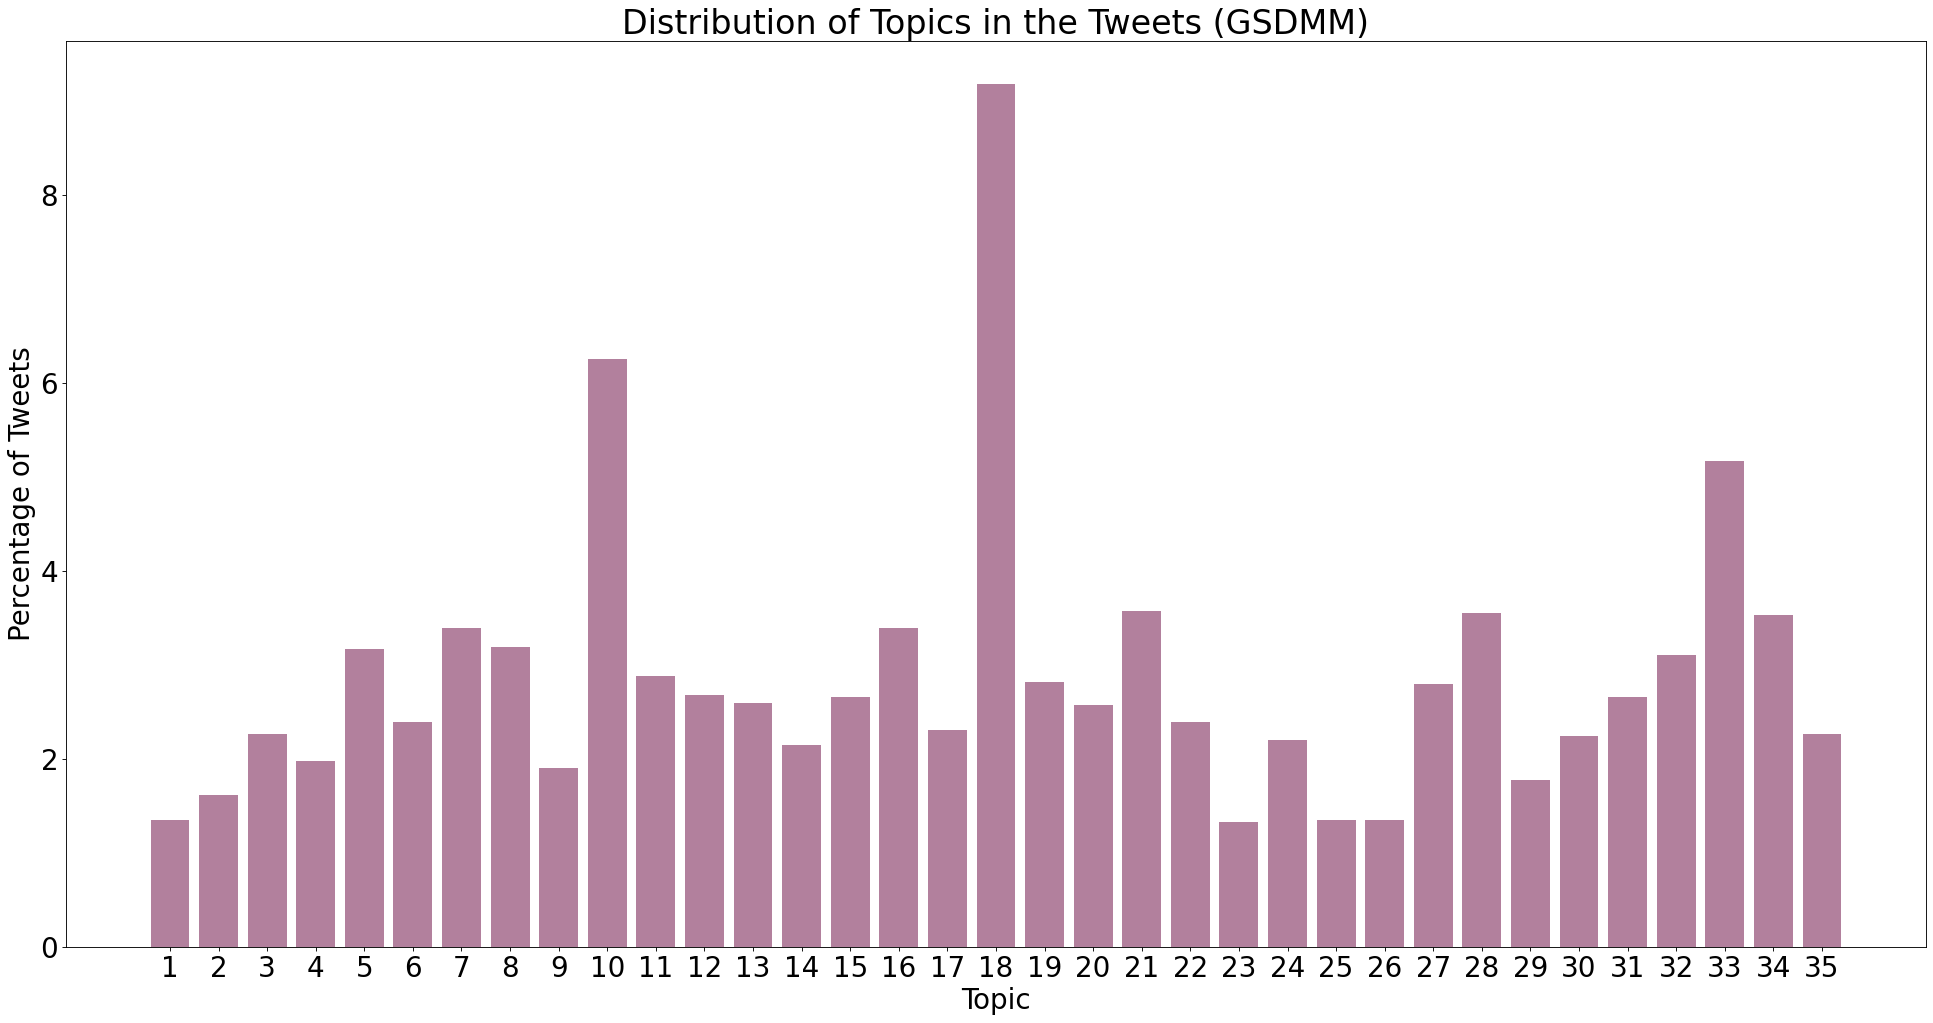

In [47]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(30, 15), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 25})

plt.bar(sttm_dist.sttm_topic, sttm_dist.pct, align='center', alpha=0.5, color='#66023C');
plt.xlabel('Topic');
plt.xticks(np.arange(np.min(sttm_dist.sttm_topic), np.max(sttm_dist.sttm_topic)+1, 1));
plt.ylabel('Percentage of Tweets');
plt.title('Distribution of Topics in the Tweets (GSDMM)');

In [48]:
sttm_dist.sort_values(by=['pct'], ascending=False).head()

,sttm_topic,Tweet.Id,sum,pct
17,18,414,4511,9.177566
9,10,282,4511,6.251386
32,33,233,4511,5.165152
20,21,161,4511,3.569053
27,28,160,4511,3.546885


In [49]:
sttm_dist['pct'].sum()

100.0

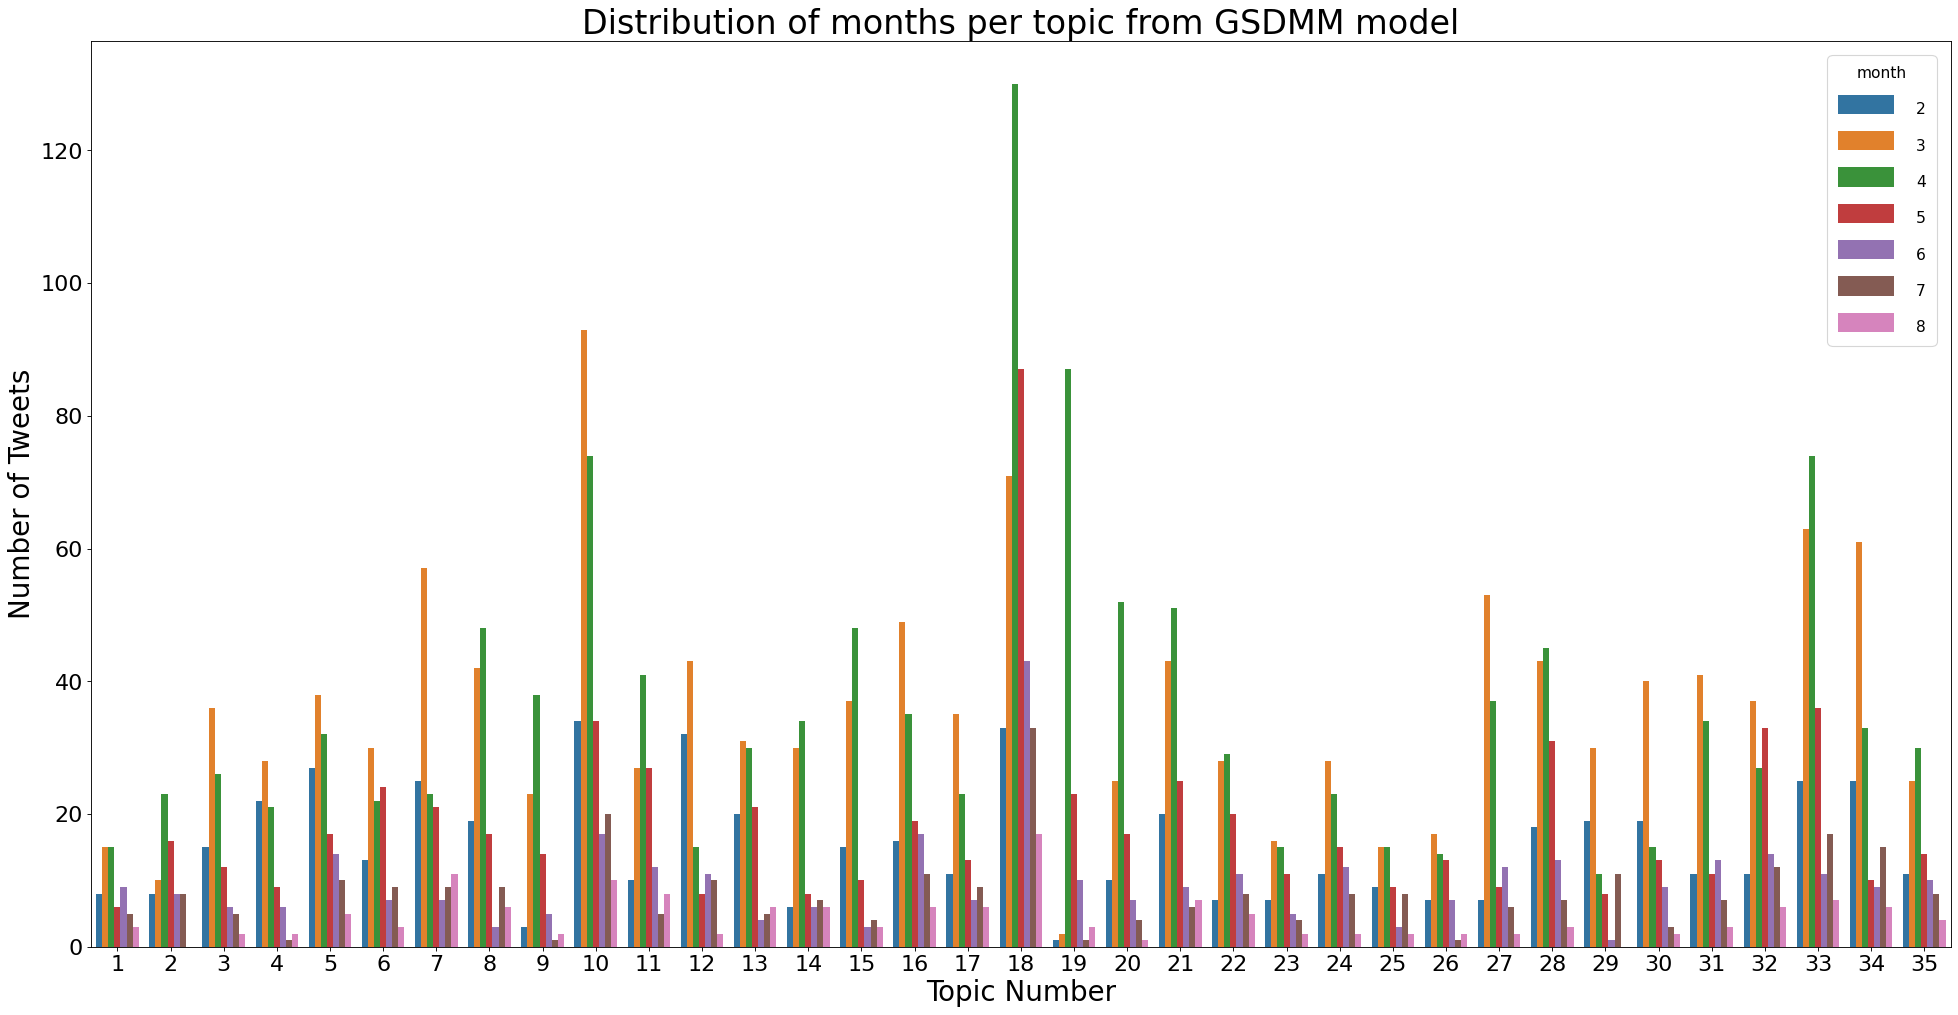

In [50]:
#BY RAW COUNT OF TWEETS

from matplotlib.pyplot import figure
figure(num=None, figsize=(30, 15), dpi=80, facecolor='w', edgecolor='k')

sttm_dist = df_filtered.groupby(['month', 'sttm_topic'])[['Tweet.Id']].count().reset_index()
ax = sns.barplot(x='sttm_topic', hue='month', hue_order = [2,3,4,5,6,7,8], y='Tweet.Id', data=sttm_dist);

ax.axes.set_title('Distribution of months per topic from GSDMM model',fontsize=30)
ax.set_xlabel("Topic Number",fontsize=25)
ax.set_ylabel('Number of Tweets',fontsize=25)
ax.tick_params(labelsize=20)

plt.setp(ax.get_legend().get_texts(), fontsize='14') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='14') # for legend title
plt.show();

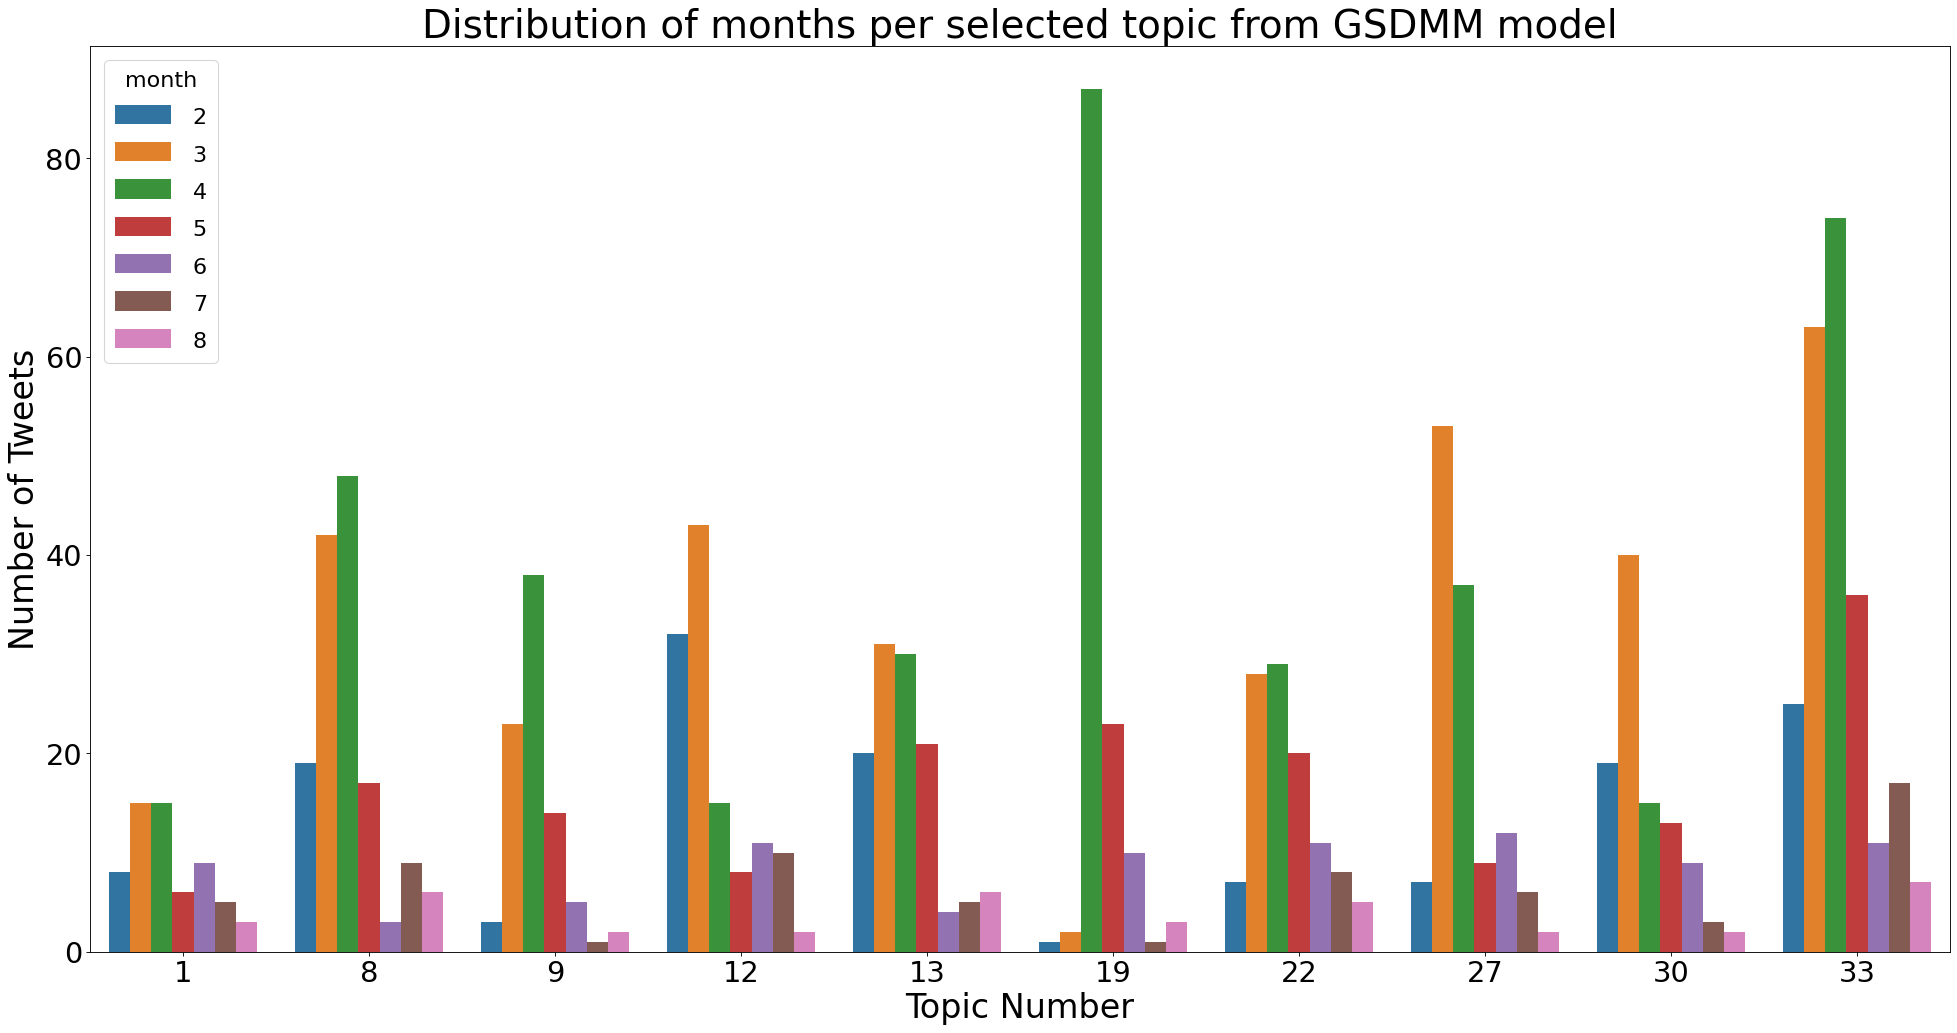

In [51]:
#BY RAW COUNT OF TWEETS

topics_of_interest = [9, 19, 8, 22, 33, 27, 13, 12, 1, 30]

sttm_dist_topics = sttm_dist[(sttm_dist['sttm_topic'].isin(topics_of_interest))]

from matplotlib.pyplot import figure
figure(num=None, figsize=(30, 15), dpi=80, facecolor='w', edgecolor='k')

ax = sns.barplot(x='sttm_topic', hue='month', hue_order = [2,3,4,5,6,7,8], y='Tweet.Id', data=sttm_dist_topics);

ax.axes.set_title('Distribution of months per selected topic from GSDMM model',fontsize=35)
ax.set_xlabel("Topic Number",fontsize=30)
ax.set_ylabel('Number of Tweets',fontsize=30)
ax.tick_params(labelsize=26)

plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='20') # for legend title
plt.show();

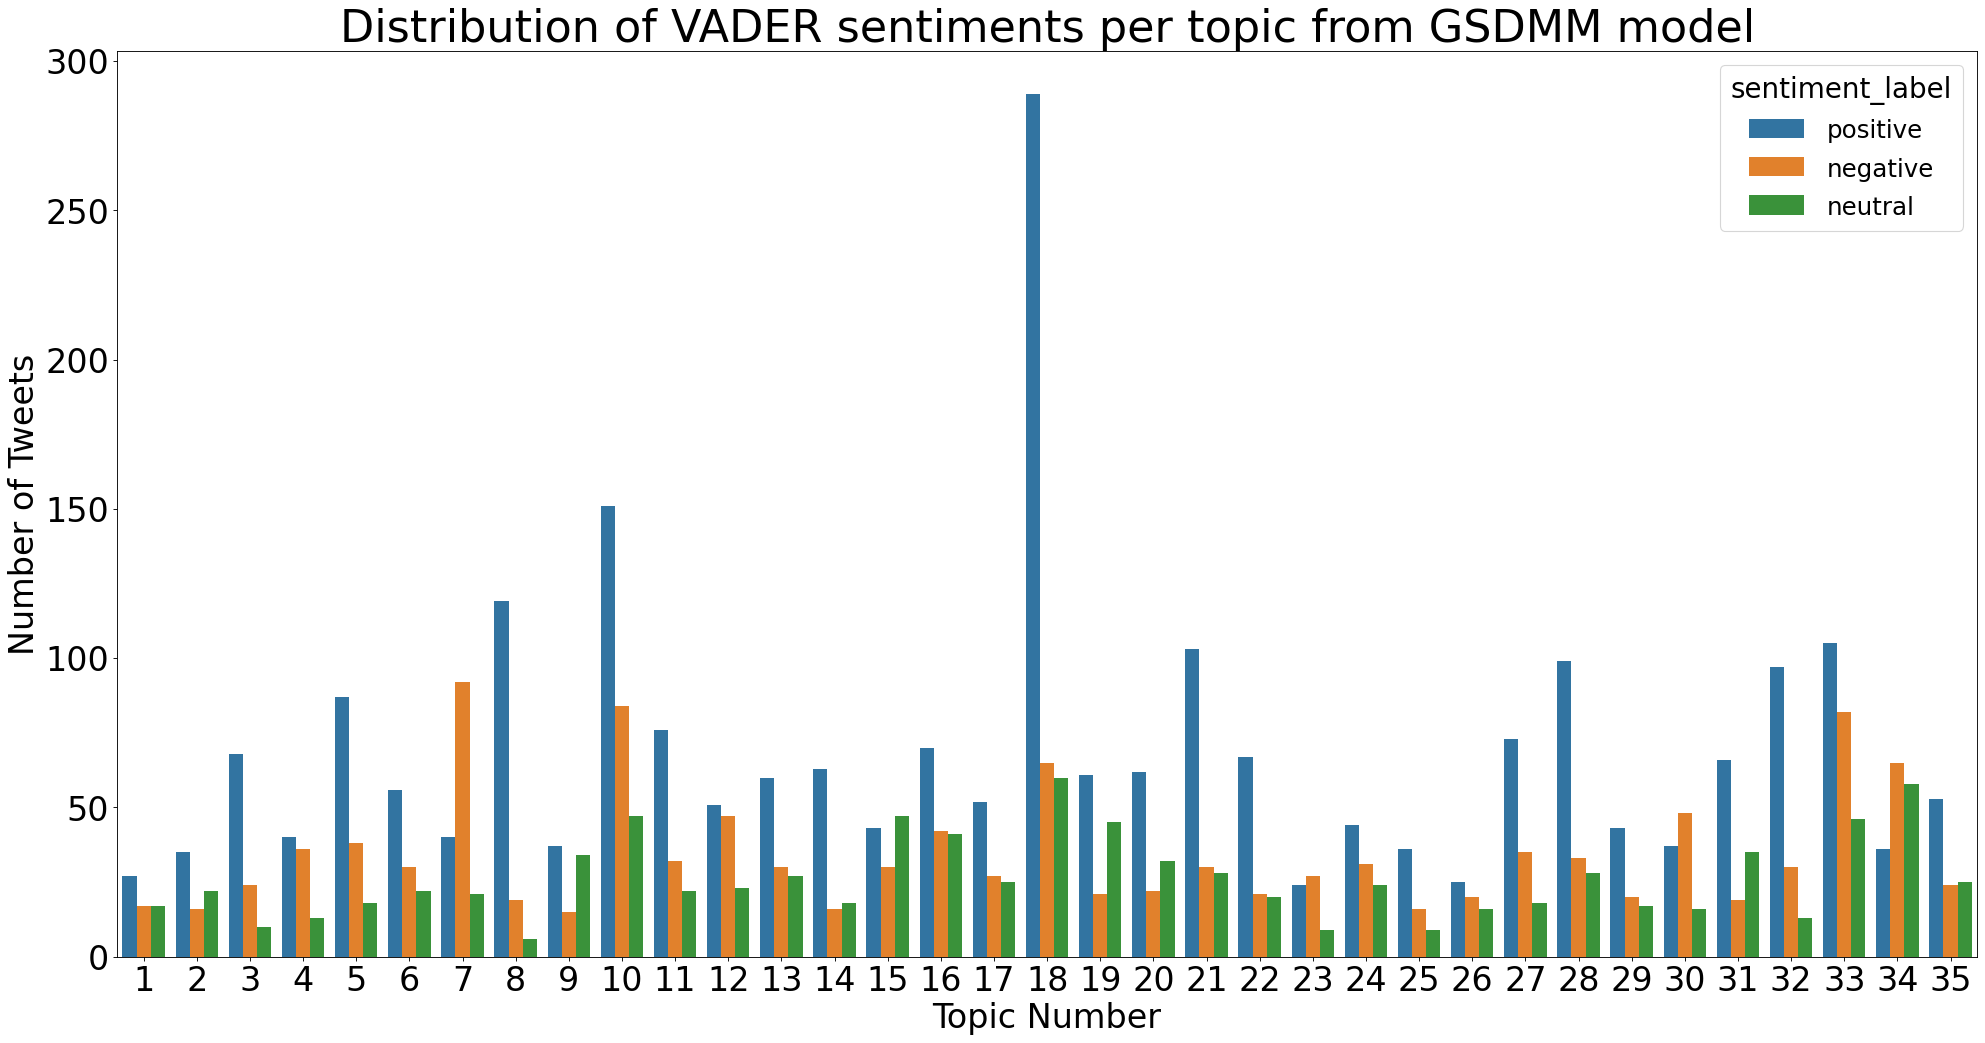

In [52]:
#BY RAW COUNT OF TWEETS

from matplotlib.pyplot import figure
figure(num=None, figsize=(30, 15), dpi=80, facecolor='w', edgecolor='k')

sttm_dist = df_filtered.groupby(['sentiment_label', 'sttm_topic'])[['Tweet.Id']].count().reset_index()
ax = sns.barplot(x='sttm_topic', hue='sentiment_label', hue_order = ["positive", "negative", "neutral"], y='Tweet.Id', data=sttm_dist);
ax.set(xlabel = 'Topic', ylabel = 'Percentage of Tweets');
ax.axes.set_title('Distribution of VADER sentiments per topic from GSDMM model',fontsize=40)
ax.set_xlabel("Topic Number",fontsize=30)
ax.set_ylabel('Number of Tweets',fontsize=30)
ax.tick_params(labelsize=30)
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='25') # for legend title
plt.rcParams['axes.facecolor'] = 'w'
plt.show();

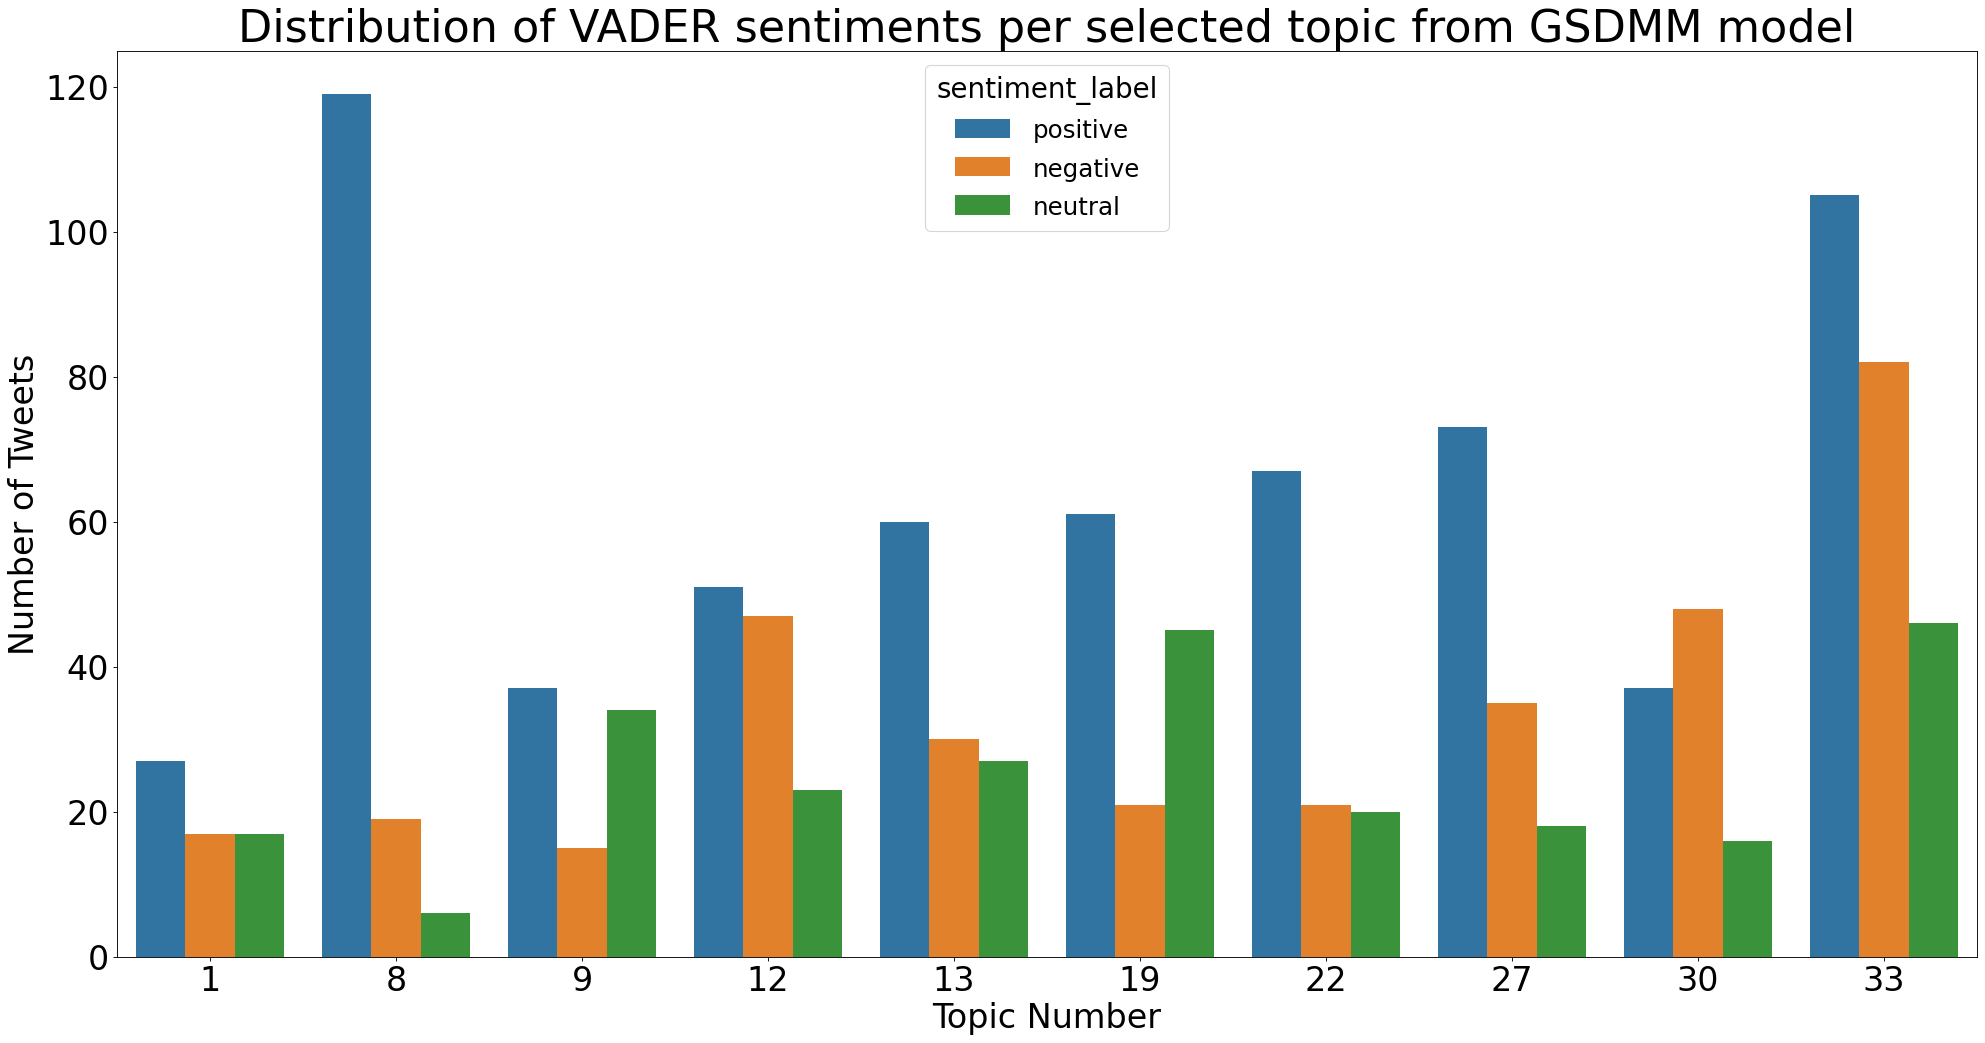

In [53]:
#BY RAW COUNT OF TWEETS

topics_of_interest = [9, 19, 8, 22, 33, 27, 13, 12, 1, 30]

sttm_dist_topics_vader = sttm_dist[(sttm_dist['sttm_topic'].isin(topics_of_interest))]

from matplotlib.pyplot import figure
figure(num=None, figsize=(30, 15), dpi=80, facecolor='w', edgecolor='k')

ax = sns.barplot(x='sttm_topic', hue='sentiment_label', hue_order = ["positive", "negative", "neutral"], y='Tweet.Id', data=sttm_dist_topics_vader);
ax.set(xlabel = 'Topic', ylabel = 'Percentage of Tweets');
ax.axes.set_title('Distribution of VADER sentiments per selected topic from GSDMM model',fontsize=40)
ax.set_xlabel("Topic Number",fontsize=30)
ax.set_ylabel('Number of Tweets',fontsize=30)
ax.tick_params(labelsize=30)
plt.setp(ax.get_legend().get_texts(), fontsize='22') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='25') # for legend title
plt.rcParams['axes.facecolor'] = 'w'
plt.show();

In [54]:
# Run these to check sample of tweets

# df_filtered[(df_filtered['sttm_topic'] ==30) & (df_filtered['sentiment_label'] =='negative')].head()
# df_filtered[(df_filtered['sttm_topic'] ==18) & (df_filtered['sentiment_label'] =='positive')].head()

In [55]:
import pandas as pd
import pyLDAvis
import math

def prepare_data(mgp):
    vocabulary = list(vocab)
    doc_topic_dists = [mgp.score(doc) for doc in docs]
    for doc in doc_topic_dists:
        for f in doc:
            assert not isinstance(f, complex)

    doc_lengths = [len(doc) for doc in docs]
    term_counts_map = {}
    for doc in docs:
        for term in doc:
            term_counts_map[term] = term_counts_map.get(term, 0) + 1
    term_counts = [term_counts_map[term] for term in vocabulary]
    doc_topic_dists2 = [[v if not math.isnan(v) else 1/K for v in d] for d in doc_topic_dists]
    doc_topic_dists2 = [d if sum(d) > 0 else [1/K]*K for d in doc_topic_dists2]
    for doc in doc_topic_dists2:
        for f in doc:
            assert not isinstance(f, complex)
    
    assert (pd.DataFrame(doc_topic_dists2).sum(axis=1) < 0.999).sum() == 0
    matrix = []
    for cluster in mgp.cluster_word_distribution:
        total = sum([occurance for word, occurance in cluster.items()])
        assert not math.isnan(total)
        # assert total > 0
        if total == 0:
            row = [(1 / len(vocabulary))] * len(vocabulary)   # <--- The discussed workaround is here
        else:
            row = [cluster.get(term, 0) / total for term in vocabulary]
        for f in row:
            assert not isinstance(f, complex)
        matrix.append(row)
    return matrix, doc_topic_dists2, doc_lengths, vocabulary, term_counts

def prepare_visualization_data(mgp):
    vis_data = pyLDAvis.prepare(*prepare_data(mgp), sort_topics=False, mds='tsne')
    with open(f"gsdmm-pyldavis-30-0.1-0.1-40.html", "w") as f:
        pyLDAvis.save_html(vis_data, f)
    return vis_data

vis_data = prepare_visualization_data(mgp)

%matplotlib inline
pyLDAvis.enable_notebook()
pyLDAvis.display(vis_data)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you spe

In [ ]:
pyLDAvis.save_html(vis_data,'pyLDAvis_submit.html')